In [2]:
import numpy as np
import pandas as pd
import lightgbm as lgb
from lightgbm import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error
from google.cloud import bigquery

In [10]:
train = pd.read_csv("./week1/train.csv")
test = pd.read_csv("./week1/test.csv")

In [4]:
test

,ForecastId,Province_State,Country_Region,Date
0,1,NaN,Afghanistan,2020-03-19
1,2,NaN,Afghanistan,2020-03-20
2,3,NaN,Afghanistan,2020-03-21
3,4,NaN,Afghanistan,2020-03-22
4,5,NaN,Afghanistan,2020-03-23
...,...,...,...,...
12637,12638,NaN,Zimbabwe,2020-04-26
12638,12639,NaN,Zimbabwe,2020-04-27
12639,12640,NaN,Zimbabwe,2020-04-28
12640,12641,NaN,Zimbabwe,2020-04-29


In [7]:
import os
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = './cedar-turbine-120710-3e76b538119a.json'

In [8]:
%%time
client = bigquery.Client()
dataset_ref = client.dataset("noaa_gsod", project="bigquery-public-data")
dataset = client.get_dataset(dataset_ref)

tables = list(client.list_tables(dataset))

table_ref = dataset_ref.table("stations")
table = client.get_table(table_ref)
stations_df = client.list_rows(table).to_dataframe()

table_ref = dataset_ref.table("gsod2020")
table = client.get_table(table_ref)
twenty_twenty_df = client.list_rows(table).to_dataframe()

stations_df['STN'] = stations_df['usaf'] + '-' + stations_df['wban']
twenty_twenty_df['STN'] = twenty_twenty_df['stn'] + '-' + twenty_twenty_df['wban']

cols_1 = ['STN', 'mo', 'da', 'temp', 'min', 'max', 'stp', 'wdsp', 'prcp', 'fog']
cols_2 = ['STN', 'country', 'state', 'call', 'lat', 'lon', 'elev']
weather_df = twenty_twenty_df[cols_1].join(stations_df[cols_2].set_index('STN'), on='STN')

weather_df.tail(10)

Wall time: 5min 24s


,STN,mo,da,temp,min,max,stp,wdsp,prcp,fog,country,state,call,lat,lon,elev
975087,477040-99999,01,12,44.1,42.8,48.2,999.9,7.7,99.99,1,JA,None,RJNK,36.395,136.407,+0011.0
975088,477040-99999,01,19,45.0,37.4,51.8,999.9,7,99.99,1,JA,None,RJNK,36.395,136.407,+0011.0
975089,477040-99999,02,08,37.3,32.0,44.6,999.9,13.8,99.99,1,JA,None,RJNK,36.395,136.407,+0011.0
975090,477040-99999,02,17,38.9,32.0,44.6,999.9,17,99.99,1,JA,None,RJNK,36.395,136.407,+0011.0
975091,477040-99999,03,15,41.6,33.8,53.6,999.9,10.9,99.99,1,JA,None,RJNK,36.395,136.407,+0011.0
975092,476040-99999,03,05,39.8,37.4,46.8,13.3,12.6,0.12,1,JA,None,None,37.900,139.017,+0005.7
975093,710790-99999,01,05,5.1,2.3,6.8,980.8,5.5,0.18,1,CA,None,CYTH,55.801,-97.864,+0222.2
975094,711210-99999,02,20,22.0,12.2,37.4,935.2,7.5,0.02,1,CA,None,CYED,53.667,-113.467,+0688.0
975095,722700-23044,02,11,48.4,36.0,60.1,877.6,6.9,0.19,1,US,TX,KELP,31.811,-106.376,+1194.2
975096,722593-03985,01,10,68.1,66.2,69.8,984.7,12.6,99.99,1,US,TX,KFWS,32.565,-97.308,+0213.4


In [11]:
%%time
from scipy.spatial.distance import cdist

weather_df['day_from_jan_first'] = (weather_df['da'].apply(int)
                                   + 31*(weather_df['mo']=='02') 
                                   + 60*(weather_df['mo']=='03')
                                   + 91*(weather_df['mo']=='04')  
                                   )

mo = train['Date'].apply(lambda x: x[5:7])
da = train['Date'].apply(lambda x: x[8:10])
train['day_from_jan_first'] = (da.apply(int)
                               + 31*(mo=='02') 
                               + 60*(mo=='03')
                               + 91*(mo=='04')  
                              )

C = []
for j in train.index:
    df = train.iloc[j:(j+1)]
    mat = cdist(df[['Lat','Long', 'day_from_jan_first']],
                weather_df[['lat','lon', 'day_from_jan_first']], 
                metric='euclidean')
    new_df = pd.DataFrame(mat, index=df.Id, columns=weather_df.index)
    arr = new_df.values
    new_close = np.where(arr == np.nanmin(arr, axis=1)[:,None],new_df.columns,False)
    L = [i[i.astype(bool)].tolist()[0] for i in new_close]
    C.append(L[0])
    
train['closest_station'] = C

train = train.set_index('closest_station').join(weather_df[['temp', 'min', 'max', 'stp', 'wdsp', 'prcp', 'fog']], ).reset_index().drop(['index'], axis=1)
train.sort_values(by=['Id'], inplace=True)
train.head()

,Id,Province/State,Country/Region,Lat,Long,Date,ConfirmedCases,Fatalities,day_from_jan_first,temp,min,max,stp,wdsp,prcp,fog
7609,1,NaN,Afghanistan,33.0,65.0,2020-01-22,0.0,0.0,22,42.6,33.6,54.9,999.9,9.4,0.00,0
15641,2,NaN,Afghanistan,33.0,65.0,2020-01-23,0.0,0.0,23,42.0,32.7,55.9,999.9,14.9,99.99,1
17699,3,NaN,Afghanistan,33.0,65.0,2020-01-24,0.0,0.0,24,40.1,36.9,43.2,999.9,10.4,0.17,1
15642,4,NaN,Afghanistan,33.0,65.0,2020-01-25,0.0,0.0,25,46.0,37.9,56.3,999.9,6.1,0.57,1
15643,5,NaN,Afghanistan,33.0,65.0,2020-01-26,0.0,0.0,26,42.8,36.1,53.1,999.9,10.8,0.00,1


In [12]:
%%time
from scipy.spatial.distance import cdist

weather_df['day_from_jan_first'] = (weather_df['da'].apply(int)
                                   + 31*(weather_df['mo']=='02') 
                                   + 60*(weather_df['mo']=='03')
                                   + 91*(weather_df['mo']=='04')  
                                   )

mo = test['Date'].apply(lambda x: x[5:7])
da = test['Date'].apply(lambda x: x[8:10])
test['day_from_jan_first'] = (da.apply(int)
                               + 31*(mo=='02') 
                               + 60*(mo=='03')
                               + 91*(mo=='04')  
                              )

C = []
for j in test.index:
    df = test.iloc[j:(j+1)]
    mat = cdist(df[['Lat','Long', 'day_from_jan_first']],
                weather_df[['lat','lon', 'day_from_jan_first']], 
                metric='euclidean')
    new_df = pd.DataFrame(mat, index=df.ForecastId, columns=weather_df.index)
    arr = new_df.values
    new_close = np.where(arr == np.nanmin(arr, axis=1)[:,None],new_df.columns,False)
    L = [i[i.astype(bool)].tolist()[0] for i in new_close]
    C.append(L[0])
    
test['closest_station'] = C

test = test.set_index('closest_station').join(weather_df[['temp', 'min', 'max', 'stp', 'wdsp', 'prcp', 'fog']], ).reset_index().drop(['index'], axis=1)
test.sort_values(by=['ForecastId'], inplace=True)
test.head()

Wall time: 13min 48s


,ForecastId,Province/State,Country/Region,Lat,Long,Date,day_from_jan_first,temp,min,max,stp,wdsp,prcp,fog
12207,1,NaN,Afghanistan,33.0,65.0,2020-03-12,72,30.7,16.9,47.7,775.4,2.9,0.0,1
10690,2,NaN,Afghanistan,33.0,65.0,2020-03-13,73,35.7,24.3,53.1,778.8,3,0.0,1
12035,3,NaN,Afghanistan,33.0,65.0,2020-03-14,74,36.4,26.8,53.4,778.2,5.3,0.0,1
2803,4,NaN,Afghanistan,33.0,65.0,2020-03-15,75,40.1,29.3,52.7,777.7,9,0.0,0
2804,5,NaN,Afghanistan,33.0,65.0,2020-03-16,76,40.1,29.3,52.7,777.7,9,0.0,0


In [13]:
train["wdsp"] = pd.to_numeric(train["wdsp"])
test["wdsp"] = pd.to_numeric(test["wdsp"])

In [14]:
train["fog"] = pd.to_numeric(train["fog"])
test["fog"] = pd.to_numeric(test["fog"])

In [15]:
X_train = train.drop(["Fatalities", "ConfirmedCases"], axis=1)

In [16]:
countries = X_train["Country/Region"]

In [17]:
countries.unique()

array(['Afghanistan', 'Albania', 'Algeria', 'Andorra',
       'Antigua and Barbuda', 'Argentina', 'Armenia', 'Aruba',
       'Australia', 'Austria', 'Azerbaijan', 'Bahrain', 'Bangladesh',
       'Barbados', 'Belarus', 'Belgium', 'Benin', 'Bhutan', 'Bolivia',
       'Bosnia and Herzegovina', 'Brazil', 'Brunei', 'Bulgaria',
       'Burkina Faso', 'Cambodia', 'Cameroon', 'Canada',
       'Central African Republic', 'Chile', 'China', 'Colombia',
       'Congo (Brazzaville)', 'Congo (Kinshasa)', 'Costa Rica',
       "Cote d'Ivoire", 'Croatia', 'Cruise Ship', 'Cuba', 'Cyprus',
       'Czechia', 'Denmark', 'Djibouti', 'Dominican Republic', 'Ecuador',
       'Egypt', 'Equatorial Guinea', 'Estonia', 'Eswatini', 'Ethiopia',
       'Finland', 'France', 'French Guiana', 'Gabon', 'Gambia, The',
       'Georgia', 'Germany', 'Ghana', 'Greece', 'Greenland', 'Guadeloupe',
       'Guam', 'Guatemala', 'Guernsey', 'Guinea', 'Guyana', 'Holy See',
       'Honduras', 'Hungary', 'Iceland', 'India', 'Indonesia

In [18]:
X_train = X_train.drop(["Id"], axis=1)
X_test = test.drop(["ForecastId"], axis=1)

In [19]:
X_train.dtypes

Province/State         object
Country/Region         object
Lat                   float64
Long                  float64
Date                   object
day_from_jan_first      int64
temp                  float64
min                   float64
max                   float64
stp                   float64
wdsp                  float64
prcp                  float64
fog                     int64
dtype: object

In [20]:
X_train['Date']= pd.to_datetime(X_train['Date']) 
X_test['Date']= pd.to_datetime(X_test['Date']) 

In [21]:
X_train = X_train.set_index(['Date'])
X_test = X_test.set_index(['Date'])

In [22]:
def create_time_features(df):
    """
    Creates time series features from datetime index
    """
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    
    X = df[['hour','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear']]
    return X

In [23]:
create_time_features(X_train)
create_time_features(X_test)

,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
Date,,,,,,,,
2020-03-12,0,3,1,3,2020,72,12,11
2020-03-13,0,4,1,3,2020,73,13,11
2020-03-14,0,5,1,3,2020,74,14,11
2020-03-15,0,6,1,3,2020,75,15,11
2020-03-16,0,0,1,3,2020,76,16,12
...,...,...,...,...,...,...,...,...
2020-04-19,0,6,2,4,2020,110,19,16
2020-04-20,0,0,2,4,2020,111,20,17
2020-04-21,0,1,2,4,2020,112,21,17


In [24]:
X_train

,Province/State,Country/Region,Lat,Long,day_from_jan_first,temp,min,max,stp,wdsp,...,fog,date,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
Date,,,,,,,,,,,,,,,,,,,,,
2020-01-22,NaN,Afghanistan,33.0000,65.0000,22,42.6,33.6,54.9,999.9,9.4,...,0,2020-01-22,0,2,1,1,2020,22,22,4
2020-01-23,NaN,Afghanistan,33.0000,65.0000,23,42.0,32.7,55.9,999.9,14.9,...,1,2020-01-23,0,3,1,1,2020,23,23,4
2020-01-24,NaN,Afghanistan,33.0000,65.0000,24,40.1,36.9,43.2,999.9,10.4,...,1,2020-01-24,0,4,1,1,2020,24,24,4
2020-01-25,NaN,Afghanistan,33.0000,65.0000,25,46.0,37.9,56.3,999.9,6.1,...,1,2020-01-25,0,5,1,1,2020,25,25,4
2020-01-26,NaN,Afghanistan,33.0000,65.0000,26,42.8,36.1,53.1,999.9,10.8,...,1,2020-01-26,0,6,1,1,2020,26,26,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-03-20,NaN,Zambia,-15.4167,28.2833,80,70.6,62.6,81.9,999.9,6.0,...,0,2020-03-20,0,4,1,3,2020,80,20,12
2020-03-21,NaN,Zambia,-15.4167,28.2833,81,71.3,66.2,81.5,999.9,7.1,...,1,2020-03-21,0,5,1,3,2020,81,21,12
2020-03-22,NaN,Zambia,-15.4167,28.2833,82,72.1,67.1,80.4,999.9,5.0,...,1,2020-03-22,0,6,1,3,2020,82,22,12


In [25]:
X_test

,Province/State,Country/Region,Lat,Long,day_from_jan_first,temp,min,max,stp,wdsp,...,fog,date,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
Date,,,,,,,,,,,,,,,,,,,,,
2020-03-12,NaN,Afghanistan,33.0000,65.0000,72,30.7,16.9,47.7,775.4,2.9,...,1,2020-03-12,0,3,1,3,2020,72,12,11
2020-03-13,NaN,Afghanistan,33.0000,65.0000,73,35.7,24.3,53.1,778.8,3.0,...,1,2020-03-13,0,4,1,3,2020,73,13,11
2020-03-14,NaN,Afghanistan,33.0000,65.0000,74,36.4,26.8,53.4,778.2,5.3,...,1,2020-03-14,0,5,1,3,2020,74,14,11
2020-03-15,NaN,Afghanistan,33.0000,65.0000,75,40.1,29.3,52.7,777.7,9.0,...,0,2020-03-15,0,6,1,3,2020,75,15,11
2020-03-16,NaN,Afghanistan,33.0000,65.0000,76,40.1,29.3,52.7,777.7,9.0,...,0,2020-03-16,0,0,1,3,2020,76,16,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-04-19,NaN,Zambia,-15.4167,28.2833,110,76.4,60.6,84.2,999.9,5.0,...,0,2020-04-19,0,6,2,4,2020,110,19,16
2020-04-20,NaN,Zambia,-15.4167,28.2833,111,76.4,60.6,84.2,999.9,5.0,...,0,2020-04-20,0,0,2,4,2020,111,20,17
2020-04-21,NaN,Zambia,-15.4167,28.2833,112,76.4,60.6,84.2,999.9,5.0,...,0,2020-04-21,0,1,2,4,2020,112,21,17


In [26]:
X_train.drop("date", axis=1, inplace=True)
X_test.drop("date", axis=1, inplace=True)

In [27]:
world_happiness_index = pd.read_csv("./World_Happiness_Index.csv")

In [28]:
world_happiness_grouped = world_happiness_index.groupby('Country name').nth(-1)

In [29]:
world_happiness_grouped.drop("Year", axis=1, inplace=True)

In [30]:
X_train = pd.merge(left=X_train, right=world_happiness_grouped, how='left', left_on='Country/Region', right_on='Country name')
X_test = pd.merge(left=X_test, right=world_happiness_grouped, how='left', left_on='Country/Region', right_on='Country name')

In [31]:
X_train

,Province/State,Country/Region,Lat,Long,day_from_jan_first,temp,min,max,stp,wdsp,...,GINI index (World Bank estimate),"GINI index (World Bank estimate), average 2000-16","gini of household income reported in Gallup, by wp5-year","Most people can be trusted, Gallup","Most people can be trusted, WVS round 1981-1984","Most people can be trusted, WVS round 1989-1993","Most people can be trusted, WVS round 1994-1998","Most people can be trusted, WVS round 1999-2004","Most people can be trusted, WVS round 2005-2009","Most people can be trusted, WVS round 2010-2014"
0,NaN,Afghanistan,33.0000,65.0000,22,42.6,33.6,54.9,999.9,9.4,...,NaN,NaN,0.290681,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,Afghanistan,33.0000,65.0000,23,42.0,32.7,55.9,999.9,14.9,...,NaN,NaN,0.290681,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,Afghanistan,33.0000,65.0000,24,40.1,36.9,43.2,999.9,10.4,...,NaN,NaN,0.290681,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,Afghanistan,33.0000,65.0000,25,46.0,37.9,56.3,999.9,6.1,...,NaN,NaN,0.290681,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,Afghanistan,33.0000,65.0000,26,42.8,36.1,53.1,999.9,10.8,...,NaN,NaN,0.290681,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17887,NaN,Zambia,-15.4167,28.2833,80,70.6,62.6,81.9,999.9,6.0,...,NaN,0.5274,0.619443,NaN,NaN,NaN,NaN,NaN,0.110429,NaN
17888,NaN,Zambia,-15.4167,28.2833,81,71.3,66.2,81.5,999.9,7.1,...,NaN,0.5274,0.619443,NaN,NaN,NaN,NaN,NaN,0.110429,NaN
17889,NaN,Zambia,-15.4167,28.2833,82,72.1,67.1,80.4,999.9,5.0,...,NaN,0.5274,0.619443,NaN,NaN,NaN,NaN,NaN,0.110429,NaN
17890,NaN,Zambia,-15.4167,28.2833,83,71.7,66.2,80.6,999.9,4.2,...,NaN,0.5274,0.619443,NaN,NaN,NaN,NaN,NaN,0.110429,NaN


In [32]:
malaria_world_health = pd.read_csv("./Malaria_World_Health_Organization.csv")

In [33]:
X_train = pd.merge(left=X_train, right=malaria_world_health, how='left', left_on='Country/Region', right_on='Country')
X_test = pd.merge(left=X_test, right=malaria_world_health, how='left', left_on='Country/Region', right_on='Country')

In [34]:
X_train

,Province/State,Country/Region,Lat,Long,day_from_jan_first,temp,min,max,stp,wdsp,...,"gini of household income reported in Gallup, by wp5-year","Most people can be trusted, Gallup","Most people can be trusted, WVS round 1981-1984","Most people can be trusted, WVS round 1989-1993","Most people can be trusted, WVS round 1994-1998","Most people can be trusted, WVS round 1999-2004","Most people can be trusted, WVS round 2005-2009","Most people can be trusted, WVS round 2010-2014",Country,Estimated number of malaria cases
0,NaN,Afghanistan,33.0000,65.0000,22,42.6,33.6,54.9,999.9,9.4,...,0.290681,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Afghanistan,630308.0
1,NaN,Afghanistan,33.0000,65.0000,23,42.0,32.7,55.9,999.9,14.9,...,0.290681,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Afghanistan,630308.0
2,NaN,Afghanistan,33.0000,65.0000,24,40.1,36.9,43.2,999.9,10.4,...,0.290681,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Afghanistan,630308.0
3,NaN,Afghanistan,33.0000,65.0000,25,46.0,37.9,56.3,999.9,6.1,...,0.290681,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Afghanistan,630308.0
4,NaN,Afghanistan,33.0000,65.0000,26,42.8,36.1,53.1,999.9,10.8,...,0.290681,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Afghanistan,630308.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17887,NaN,Zambia,-15.4167,28.2833,80,70.6,62.6,81.9,999.9,6.0,...,0.619443,NaN,NaN,NaN,NaN,NaN,0.110429,NaN,Zambia,3475522.0
17888,NaN,Zambia,-15.4167,28.2833,81,71.3,66.2,81.5,999.9,7.1,...,0.619443,NaN,NaN,NaN,NaN,NaN,0.110429,NaN,Zambia,3475522.0
17889,NaN,Zambia,-15.4167,28.2833,82,72.1,67.1,80.4,999.9,5.0,...,0.619443,NaN,NaN,NaN,NaN,NaN,0.110429,NaN,Zambia,3475522.0
17890,NaN,Zambia,-15.4167,28.2833,83,71.7,66.2,80.6,999.9,4.2,...,0.619443,NaN,NaN,NaN,NaN,NaN,0.110429,NaN,Zambia,3475522.0


In [35]:
X_train.drop("Country", axis=1, inplace=True)
X_test.drop("Country", axis=1, inplace=True)

In [36]:
human_development_index = pd.read_csv("./Human_Development_Index.csv")

In [37]:
X_train = pd.merge(left=X_train, right=human_development_index, how='left', left_on='Country/Region', right_on='Country')
X_test = pd.merge(left=X_test, right=human_development_index, how='left', left_on='Country/Region', right_on='Country')

In [38]:
X_train

,Province/State,Country/Region,Lat,Long,day_from_jan_first,temp,min,max,stp,wdsp,...,"Most people can be trusted, WVS round 1999-2004","Most people can be trusted, WVS round 2005-2009","Most people can be trusted, WVS round 2010-2014",Estimated number of malaria cases,Country,Human development index (HDI) 2018,Life expectancy at birth 2018,Expected years of schooling 2018,Mean years of schooling 2018,Gross national income (GNI) per capita 2018
0,NaN,Afghanistan,33.0000,65.0000,22,42.6,33.6,54.9,999.9,9.4,...,NaN,NaN,NaN,630308.0,Afghanistan,0.496,64.5,10.1,3.9,"1,746"
1,NaN,Afghanistan,33.0000,65.0000,23,42.0,32.7,55.9,999.9,14.9,...,NaN,NaN,NaN,630308.0,Afghanistan,0.496,64.5,10.1,3.9,"1,746"
2,NaN,Afghanistan,33.0000,65.0000,24,40.1,36.9,43.2,999.9,10.4,...,NaN,NaN,NaN,630308.0,Afghanistan,0.496,64.5,10.1,3.9,"1,746"
3,NaN,Afghanistan,33.0000,65.0000,25,46.0,37.9,56.3,999.9,6.1,...,NaN,NaN,NaN,630308.0,Afghanistan,0.496,64.5,10.1,3.9,"1,746"
4,NaN,Afghanistan,33.0000,65.0000,26,42.8,36.1,53.1,999.9,10.8,...,NaN,NaN,NaN,630308.0,Afghanistan,0.496,64.5,10.1,3.9,"1,746"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17887,NaN,Zambia,-15.4167,28.2833,80,70.6,62.6,81.9,999.9,6.0,...,NaN,0.110429,NaN,3475522.0,Zambia,0.591,63.5,12.1,7.1,"3,582"
17888,NaN,Zambia,-15.4167,28.2833,81,71.3,66.2,81.5,999.9,7.1,...,NaN,0.110429,NaN,3475522.0,Zambia,0.591,63.5,12.1,7.1,"3,582"
17889,NaN,Zambia,-15.4167,28.2833,82,72.1,67.1,80.4,999.9,5.0,...,NaN,0.110429,NaN,3475522.0,Zambia,0.591,63.5,12.1,7.1,"3,582"
17890,NaN,Zambia,-15.4167,28.2833,83,71.7,66.2,80.6,999.9,4.2,...,NaN,0.110429,NaN,3475522.0,Zambia,0.591,63.5,12.1,7.1,"3,582"


In [39]:
X_train.drop(["Country", "Gross national income (GNI) per capita 2018"], axis=1, inplace=True)
X_test.drop(["Country", "Gross national income (GNI) per capita 2018"], axis=1, inplace=True)

In [40]:
night_ranger_predictors = pd.read_csv("./covid19_by_country.csv")

In [41]:
#There is a duplicate for Georgia in this dataset from Night Ranger, causing merge issues so we will just drop the Georgia rows
night_ranger_predictors = night_ranger_predictors[night_ranger_predictors.Country != "Georgia"]

In [42]:
X_train = pd.merge(left=X_train, right=night_ranger_predictors, how='left', left_on='Country/Region', right_on='Country')
X_test = pd.merge(left=X_test, right=night_ranger_predictors, how='left', left_on='Country/Region', right_on='Country')

In [43]:
X_train

,Province/State,Country/Region,Lat,Long,day_from_jan_first,temp,min,max,stp,wdsp,...,Male Lung,Median Age,GDP 2018,Crime Index,Population 2020,Smoking 2016,Females 2018,Total Infected,Total Deaths,Total Recovered
0,NaN,Afghanistan,33.0000,65.0000,22,42.6,33.6,54.9,999.9,9.4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,Afghanistan,33.0000,65.0000,23,42.0,32.7,55.9,999.9,14.9,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,Afghanistan,33.0000,65.0000,24,40.1,36.9,43.2,999.9,10.4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,Afghanistan,33.0000,65.0000,25,46.0,37.9,56.3,999.9,6.1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,Afghanistan,33.0000,65.0000,26,42.8,36.1,53.1,999.9,10.8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17887,NaN,Zambia,-15.4167,28.2833,80,70.6,62.6,81.9,999.9,6.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17888,NaN,Zambia,-15.4167,28.2833,81,71.3,66.2,81.5,999.9,7.1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17889,NaN,Zambia,-15.4167,28.2833,82,72.1,67.1,80.4,999.9,5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17890,NaN,Zambia,-15.4167,28.2833,83,71.7,66.2,80.6,999.9,4.2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [44]:
X_train.drop(["Country", "Restrictions","Quarantine", "Schools", "Total Infected", "Total Deaths"], axis=1, inplace=True)
X_test.drop(["Country", "Restrictions","Quarantine", "Schools", "Total Infected", "Total Deaths"], axis=1, inplace=True)

In [45]:
X_train.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17892 entries, 0 to 17891
Data columns (total 71 columns):
Province/State                                              8190 non-null object
Country/Region                                              17892 non-null object
Lat                                                         17892 non-null float64
Long                                                        17892 non-null float64
day_from_jan_first                                          17892 non-null int64
temp                                                        17892 non-null float64
min                                                         17892 non-null float64
max                                                         17892 non-null float64
stp                                                         17892 non-null float64
wdsp                                                        17892 non-null float64
prcp                                                        17892 

In [46]:
X_test

,Province/State,Country/Region,Lat,Long,day_from_jan_first,temp,min,max,stp,wdsp,...,lung,Female Lung,Male Lung,Median Age,GDP 2018,Crime Index,Population 2020,Smoking 2016,Females 2018,Total Recovered
0,NaN,Afghanistan,33.0000,65.0000,72,30.7,16.9,47.7,775.4,2.9,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,Afghanistan,33.0000,65.0000,73,35.7,24.3,53.1,778.8,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,Afghanistan,33.0000,65.0000,74,36.4,26.8,53.4,778.2,5.3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,Afghanistan,33.0000,65.0000,75,40.1,29.3,52.7,777.7,9.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,Afghanistan,33.0000,65.0000,76,40.1,29.3,52.7,777.7,9.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12207,NaN,Zambia,-15.4167,28.2833,110,76.4,60.6,84.2,999.9,5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12208,NaN,Zambia,-15.4167,28.2833,111,76.4,60.6,84.2,999.9,5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12209,NaN,Zambia,-15.4167,28.2833,112,76.4,60.6,84.2,999.9,5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12210,NaN,Zambia,-15.4167,28.2833,113,76.4,60.6,84.2,999.9,5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [47]:
X_train = pd.concat([X_train,pd.get_dummies(X_train['Province/State'], prefix='ps')],axis=1)
X_train.drop(['Province/State'],axis=1, inplace=True)
X_test = pd.concat([X_test,pd.get_dummies(X_test['Province/State'], prefix='ps')],axis=1)
X_test.drop(['Province/State'],axis=1, inplace=True)

In [48]:
X_train = pd.concat([X_train,pd.get_dummies(X_train['Country/Region'], prefix='cr')],axis=1)
X_train.drop(['Country/Region'],axis=1, inplace=True)
X_test = pd.concat([X_test,pd.get_dummies(X_test['Country/Region'], prefix='cr')],axis=1)
X_test.drop(['Country/Region'],axis=1, inplace=True)

In [49]:
y_train = train["Fatalities"]

In [50]:
y_train

7609     0.0
15641    0.0
17699    0.0
15642    0.0
15643    0.0
        ... 
5931     0.0
14733    0.0
17275    0.0
4770     0.0
4771     0.0
Name: Fatalities, Length: 17892, dtype: float64

In [51]:
X_train

,Lat,Long,day_from_jan_first,temp,min,max,stp,wdsp,prcp,fog,...,cr_Turkey,cr_US,cr_Ukraine,cr_United Arab Emirates,cr_United Kingdom,cr_Uruguay,cr_Uzbekistan,cr_Venezuela,cr_Vietnam,cr_Zambia
0,33.0000,65.0000,22,42.6,33.6,54.9,999.9,9.4,0.00,0,...,0,0,0,0,0,0,0,0,0,0
1,33.0000,65.0000,23,42.0,32.7,55.9,999.9,14.9,99.99,1,...,0,0,0,0,0,0,0,0,0,0
2,33.0000,65.0000,24,40.1,36.9,43.2,999.9,10.4,0.17,1,...,0,0,0,0,0,0,0,0,0,0
3,33.0000,65.0000,25,46.0,37.9,56.3,999.9,6.1,0.57,1,...,0,0,0,0,0,0,0,0,0,0
4,33.0000,65.0000,26,42.8,36.1,53.1,999.9,10.8,0.00,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17887,-15.4167,28.2833,80,70.6,62.6,81.9,999.9,6.0,0.00,0,...,0,0,0,0,0,0,0,0,0,1
17888,-15.4167,28.2833,81,71.3,66.2,81.5,999.9,7.1,99.99,1,...,0,0,0,0,0,0,0,0,0,1
17889,-15.4167,28.2833,82,72.1,67.1,80.4,999.9,5.0,99.99,1,...,0,0,0,0,0,0,0,0,0,1
17890,-15.4167,28.2833,83,71.7,66.2,80.6,999.9,4.2,0.00,0,...,0,0,0,0,0,0,0,0,0,1


In [63]:
X_train.info(verbose=True)X_train

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17892 entries, 0 to 17891
Data columns (total 360 columns):
lat                                                 float64
long                                                float64
day_from_jan_first                                  int64
temp                                                float64
min                                                 float64
max                                                 float64
stp                                                 float64
wdsp                                                float64
prcp                                                float64
fog                                                 int64
hour                                                int64
dayofweek                                           int64
quarter                                             int64
month                                               int64
year                                                int64
dayo

In [54]:
reg = lgb.LGBMRegressor(n_estimators=1000)

In [62]:
X_train.columns = X_train.columns.map(lambda x: x.lower().replace('-', '_').replace(',', '_').replace('(', '').replace(')', '').replace(' ', ''))
X_test.columns = X_test.columns.map(lambda x: x.lower().replace('-', '_').replace(',', '_').replace('(', '').replace(')', '').replace(' ', ''))

In [65]:
reg.fit(X_train, y_train, verbose=True)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=1000, n_jobs=-1, num_leaves=31, objective=None,
              random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

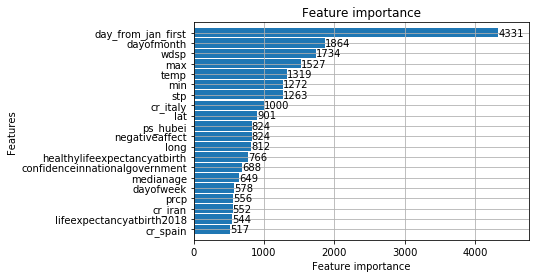

In [66]:
plot = plot_importance(reg, height=0.9, max_num_features=20)

In [67]:
y_train = train.groupby(["Country/Region"]).Fatalities.pct_change(periods=1)

In [68]:
y_train = y_train.replace(np.nan, 0)

In [69]:
y_train = y_train.replace(np.inf, 0)

In [70]:
reg = lgb.LGBMRegressor(n_estimators=1000)

In [71]:
reg.fit(X_train, y_train, verbose=True)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=1000, n_jobs=-1, num_leaves=31, objective=None,
              random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

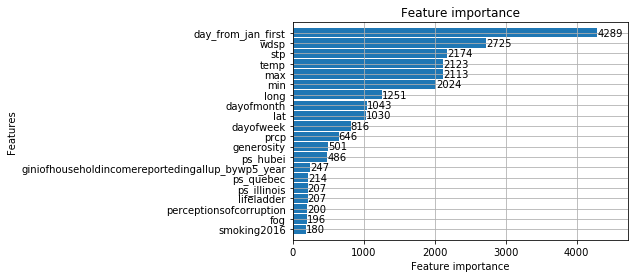

In [72]:
plot = plot_importance(reg, height=0.9, max_num_features=20)

In [73]:
y_train = train["ConfirmedCases"]

In [74]:
reg = lgb.LGBMRegressor(n_estimators=1000)

In [75]:
reg.fit(X_train, y_train, verbose=True)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=1000, n_jobs=-1, num_leaves=31, objective=None,
              random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

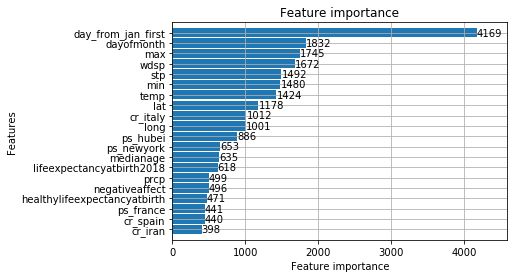

In [76]:
plot = plot_importance(reg, height=0.9, max_num_features=20)

In [77]:
y_train = train.groupby(["Country/Region"]).ConfirmedCases.pct_change(periods=1)

In [78]:
y_train = y_train.replace(np.nan, 0)

In [79]:
y_train = y_train.replace(np.inf, 0)

In [80]:
reg = lgb.LGBMRegressor(n_estimators=1000)

In [81]:
reg.fit(X_train, y_train, verbose=True)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=1000, n_jobs=-1, num_leaves=31, objective=None,
              random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

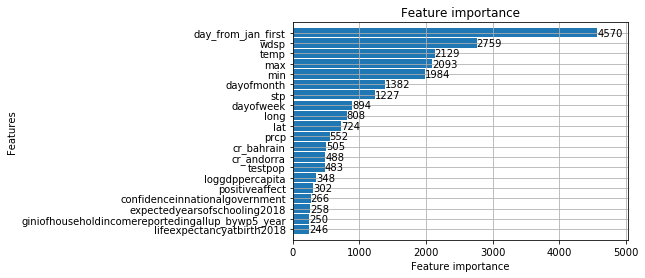

In [82]:
plot = plot_importance(reg, height=0.9, max_num_features=20)

In [84]:
y_train = train["ConfirmedCases"]
confirmed_reg = lgb.LGBMRegressor(n_estimators=1000)
confirmed_reg.fit(X_train, y_train, verbose=True)
preds = confirmed_reg.predict(X_test)
preds = np.array(preds)
preds[preds < 0] = 0
preds = np.round(preds, 0)

In [85]:
preds = np.array(preds)

In [86]:
submissionOrig = pd.read_csv("./week1/submission.csv")

In [87]:
submissionOrig["ConfirmedCases"]=pd.Series(preds)

In [88]:
submissionOrig

,ForecastId,ConfirmedCases,Fatalities
0,1,0.0,1
1,2,59.0,1
2,3,29.0,1
3,4,0.0,1
4,5,0.0,1
...,...,...,...
12207,12208,0.0,1
12208,12209,0.0,1
12209,12210,0.0,1
12210,12211,0.0,1


In [89]:
test = test.join(submissionOrig["ConfirmedCases"])
test["Difference"] = test.groupby(["Country/Region"])["ConfirmedCases"].apply(lambda x: x.shift(1) - x)
for index, row in test.iterrows():
    if index>0:
        if row["Difference"] < 0:
            test.at[index,"ConfirmedCases"] = test.iloc[index-1]["ConfirmedCases"]

In [90]:
submissionOrig["ConfirmedCases"] = test["ConfirmedCases"]
test.drop("ConfirmedCases", axis=1, inplace=True)

In [91]:
y_train = train["Fatalities"]
confirmed_reg = lgb.LGBMRegressor(n_estimators=1000)
confirmed_reg.fit(X_train, y_train, verbose=True)
preds = confirmed_reg.predict(X_test)
preds = np.array(preds)
preds[preds < 0] = 0
preds = np.round(preds, 0)
submissionOrig["Fatalities"]=pd.Series(preds)

In [92]:
test = test.join(submissionOrig["Fatalities"])
test["Difference"] = test.groupby(["Country/Region"])["Fatalities"].apply(lambda x: x.shift(1) - x)
for index, row in test.iterrows():
    if index>0:
        if row["Difference"] < 0:
            test.at[index,"Fatalities"] = test.iloc[index-1]["Fatalities"]

In [93]:
submissionOrig["Fatalities"] = test["Fatalities"]
test.drop("Fatalities", axis=1, inplace=True)

In [94]:
submissionOrigsubmissionOrig.to_csv('submission.csv',index=False)

,ForecastId,ConfirmedCases,Fatalities
0,1,0.0,1.0
1,2,0.0,0.0
2,3,143.0,0.0
3,4,0.0,0.0
4,5,0.0,0.0
...,...,...,...
12207,12208,0.0,1.0
12208,12209,0.0,0.0
12209,12210,0.0,0.0
12210,12211,0.0,0.0


In [95]:
submissionOrig.to_csv('week1-lgb-submission.csv',index=False)